Number of high-PCN plasmids (>30): 424
Number of control plasmids (≤30): 6579
Selected 1288 domain columns from '2-Hacid_dh' to 'zf-dskA_traR'
Saved domain enrichment statistics to: /mnt/e/Figure_files/Fig_5/Final/New folder/New folder/domain_enrichment_stats2.csv
Plotting 19 domains enriched in high-PCN plasmids


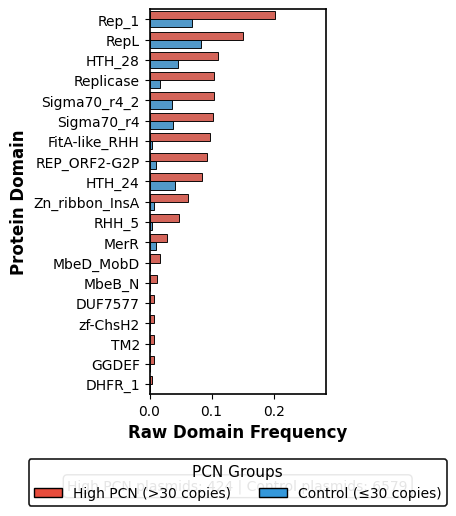

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection  

# 1. Load the filtered data
df = pd.read_csv('Figure_5I_data.csv', low_memory=False)  

# 2. Filter for Human-associated data
human_data = df[df['ecosystem_group'] == 'Human_associated'].copy()

# 3. Split into high-PCN (>30) and control (<=30) groups
high_pcn = human_data[human_data['PCN'] > 30]
control = human_data[human_data['PCN'] <= 30]

# Print plasmid counts
print(f"Number of high-PCN plasmids (>30): {len(high_pcn)}")
print(f"Number of control plasmids (≤30): {len(control)}")

# Apply the function to extract phylum and class
human_data[['phylum', 'class']] = human_data['host_taxonomy'].apply(lambda x: pd.Series(extract_taxonomy(x)))
human_data['class'] = human_data['class'].fillna('No class')

# 5. Create combined 'phylum_class' label
human_data['phylum_class'] = human_data['phylum'] + " ; " + human_data['class']

# 6. Select domain columns by position
start_col = '2-Hacid_dh'
end_col = 'zf-dskA_traR'

# Verify the columns exist
if start_col not in df.columns:
    raise ValueError(f"Start column '{start_col}' not found in DataFrame columns")
if end_col not in df.columns:
    raise ValueError(f"End column '{end_col}' not found in DataFrame columns")

# Get the domain columns
start_idx = df.columns.get_loc(start_col)
end_idx = df.columns.get_loc(end_col)
domain_columns = df.columns[start_idx:end_idx + 1].tolist()

print(f"Selected {len(domain_columns)} domain columns from '{start_col}' to '{end_col}'")

# 7. Calculate mean frequency of each domain for both groups (using raw frequencies)
high_pcn_domains = high_pcn[domain_columns].mean(axis=0)
control_domains = control[domain_columns].mean(axis=0)

# 8. Normalize by the maximum frequency of any domain in each group (but we'll not use this for plotting)
high_pcn_max = high_pcn_domains.max()
control_max = control_domains.max()

high_pcn_domains_normalized = high_pcn_domains / high_pcn_max
control_domains_normalized = control_domains / control_max

# 9. Combine the frequencies into a single DataFrame using raw frequencies (not normalized)
domain_frequencies = pd.DataFrame({
    'high_pcn_freq': high_pcn_domains,  # Raw frequency
    'control_freq': control_domains,    # Raw frequency
    'high_pcn_freq_normalized': high_pcn_domains_normalized,
    'control_freq_normalized': control_domains_normalized
})

# 10. Calculate absolute difference and fold enrichment based on RAW frequencies
domain_frequencies['abs_difference'] = domain_frequencies['high_pcn_freq'] - domain_frequencies['control_freq']
domain_frequencies['fold_enrichment'] = domain_frequencies['high_pcn_freq'] / domain_frequencies['control_freq'].replace(0, 1e-5)  # Avoid division by zero

# 11. Perform Mann-Whitney U test for each domain
p_values = []
for domain in domain_columns:
    high_pcn_data = high_pcn[domain].dropna()
    control_data = control[domain].dropna()
    
    if len(high_pcn_data) < 2 or len(control_data) < 2:
        p_values.append(np.nan)
        continue
    
    # Use one-tailed test for enrichment in high-PCN group
    _, p_value = mannwhitneyu(high_pcn_data, control_data, alternative='greater')
    p_values.append(p_value)

# 12. Apply FDR correction
valid_mask = ~np.isnan(p_values)
valid_pvals = np.array(p_values)[valid_mask]

# Apply FDR correction
rejected, corrected_pvals = fdrcorrection(valid_pvals, alpha=0.05)

# Apply back to domain_frequencies
domain_frequencies['p_value'] = np.nan
domain_frequencies['p_value_corrected'] = np.nan
domain_frequencies.loc[valid_mask, 'p_value'] = p_values
domain_frequencies.loc[valid_mask, 'p_value_corrected'] = corrected_pvals

# 13. Add -log10(p-value) to the DataFrame
domain_frequencies['neg_log10_p'] = -np.log10(domain_frequencies['p_value_corrected'].replace(0, 1e-300))

# 14. Clean infinite values
domain_frequencies.replace([np.inf, -np.inf], np.nan, inplace=True)

# 15. Save intermediate file with domain statistics
intermediate_file = 'domain_enrichment_stats2.csv'
domain_frequencies.to_csv(intermediate_file, index_label='domain')
print(f"Saved domain enrichment statistics to: {intermediate_file}")

# 16. Remove rows with NaN for plotting
plot_data = domain_frequencies.dropna(subset=['abs_difference', 'neg_log10_p']).sort_values('abs_difference', ascending=False)

# 17. FILTER: Only domains significantly enriched in high-PCN (FDR-corrected p < 0.05 AND fold_enrichment > 1)
enriched_domains = plot_data[ 
    (plot_data['p_value_corrected'] < 0.05) & 
    (plot_data['fold_enrichment'] > 1)
]

# OPTION 1: Horizontal Bar Plot with Raw Frequencies (no normalized frequencies used)
if not enriched_domains.empty:
    # Select top 20 by fold enrichment (most enriched first)
    top_domains = enriched_domains.sort_values('fold_enrichment', ascending=False).head(20)
    
    print(f"Plotting {len(top_domains)} domains enriched in high-PCN plasmids")
    
    # Create a long-form DataFrame for plotting using raw frequencies (not normalized)
    plot_df = pd.DataFrame({
        'Domain': np.tile(top_domains.index, 2),
        'Raw Frequency': np.concatenate([top_domains['high_pcn_freq'], top_domains['control_freq']]),
        'Group': np.repeat(['High PCN (>30)', 'Control (≤30)'], len(top_domains))
    })
    
    # Sort the data by Raw Frequency in descending order for top-to-bottom arrangement
    plot_df = plot_df.sort_values('Raw Frequency', ascending=False)

    # Create horizontal bar plot
    plt.figure(figsize=(4, 5))  # Slightly wider to accommodate the box
    ax = sns.barplot(
        data=plot_df,
        x='Raw Frequency',
        y='Domain',
        hue='Group',
        palette={'High PCN (>30)': '#E74C3C', 'Control (≤30)': '#3498DB'},
        alpha=0.95,
        linewidth=0.7,
        edgecolor='black'
    )
    
    # Customize plot appearance
    plt.xlabel('Raw Domain Frequency', fontsize=12, fontweight='bold')
    plt.ylabel('Protein Domain', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Set axis limits
    max_freq = plot_df['Raw Frequency'].max()
    plt.xlim(0, min(1.0, max_freq * 1.4))
    
    # Create custom legend with PCN definitions
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#E74C3C', edgecolor='black', label='High PCN (>30 copies)'),
        Patch(facecolor='#3498DB', edgecolor='black', label='Control (≤30 copies)')
    ]
    
    # Add legend outside the plot with a box
    legend = plt.legend(
        handles=legend_elements,
        title='PCN Groups',
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        framealpha=0.9,
        fancybox=True,
        shadow=False,
        fontsize=10,
        title_fontsize=11
    )
    
    # Draw a box around the legend
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(1.2)
    
    # Add plasmid counts inside the box
    plt.text(
        0.5, -0.22,  # Position below the legend
        f"High PCN plasmids: {len(high_pcn)} | Control plasmids: {len(control)}",
        ha='center',
        va='top',
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', pad=0.3)
    )
    
    # Remove grid lines
    plt.grid(False)
    
    # Add enclosed box around main plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)
    
    # Adjust layout to make space for the external box
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make space for the legend box
    
    # Save the plot
    plt.savefig('Figure_5I.pdf', 
                dpi=1200, bbox_inches='tight')
    plt.show()
